In [3]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

def setup_plotting_style():
    """Set consistent plotting style across all visualizations"""
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12

print("=== TASK 3: CROSS-COUNTRY COMPARISON ===")
setup_plotting_style()

=== TASK 3: CROSS-COUNTRY COMPARISON ===


In [9]:
# Cell 2: Case-sensitive loading
def load_country_data_exact(countries: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Load data with exact filename matching
    """
    data_dict = {}
    
    # Map country names to exact filenames
    file_mapping = {
        'Benin': 'benin_clean.csv',
        'Togo': 'togo_clean.csv', 
        'Sierra Leone': 'sierraleone_clean.csv'  # Note the exact filename
    }
    
    for country in countries:
        filename = file_mapping[country]
        possible_paths = [
            f'data/{filename}',
            f'../data/{filename}',
            f'./data/{filename}',
            filename
        ]
        
        loaded = False
        for path in possible_paths:
            if os.path.exists(path):
                try:
                    df = pd.read_csv(path)
                    df['Country'] = country
                    data_dict[country] = df
                    print(f"✅ {country} loaded from: {path} | Shape: {df.shape}")
                    loaded = True
                    break
                except Exception as e:
                    print(f"❌ Error loading {country}: {e}")
        
        if not loaded:
            print(f"❌ Could not find {filename} for {country}")
    
    return data_dict

# Try with exact filenames
print("=== LOADING WITH EXACT FILENAMES ===")
data_dict = load_country_data_exact(countries)
combined_df = combine_country_data(data_dict)

=== LOADING WITH EXACT FILENAMES ===
✅ Benin loaded from: ../data/benin_clean.csv | Shape: (525600, 31)
✅ Togo loaded from: ../data/togo_clean.csv | Shape: (525600, 30)
✅ Sierra Leone loaded from: ../data/sierraleone_clean.csv | Shape: (525600, 30)
Combined dataset: (1576800, 31)


=== 1. SOLAR METRICS COMPARISON ===


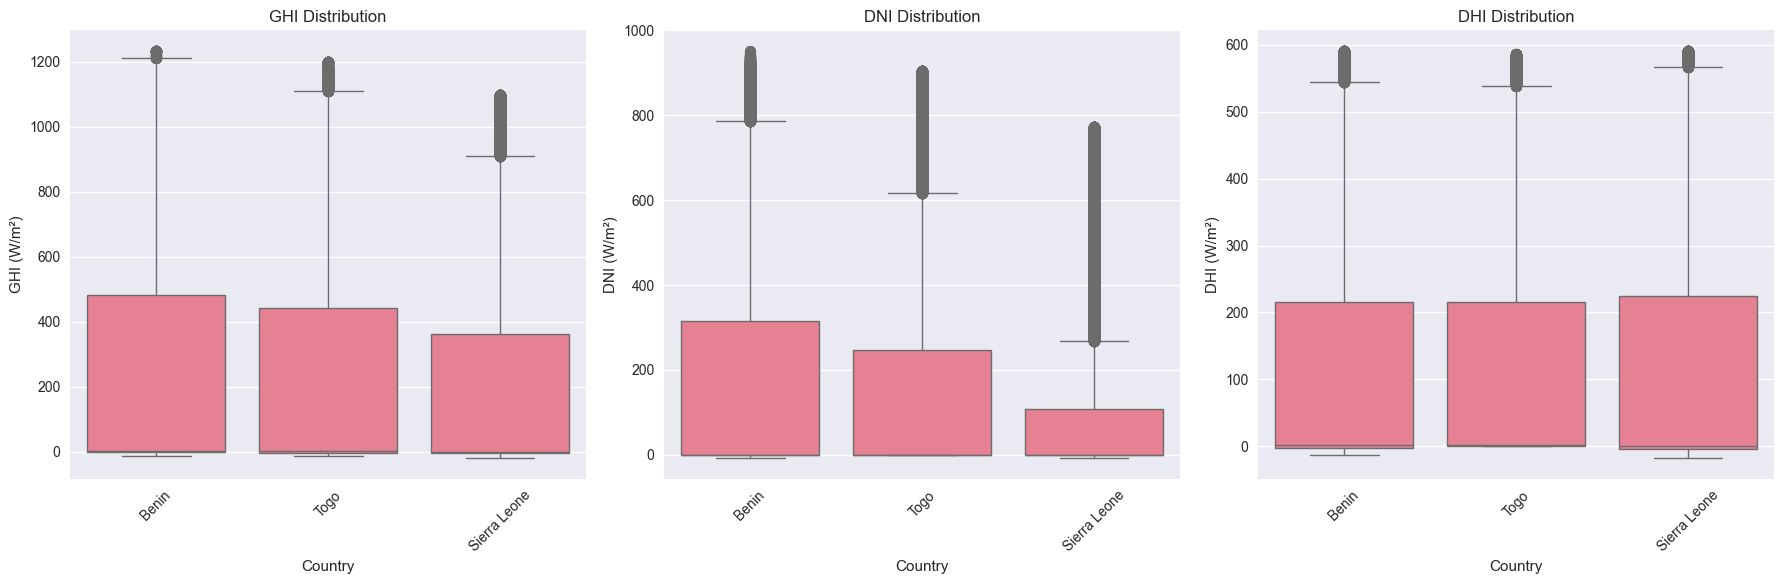

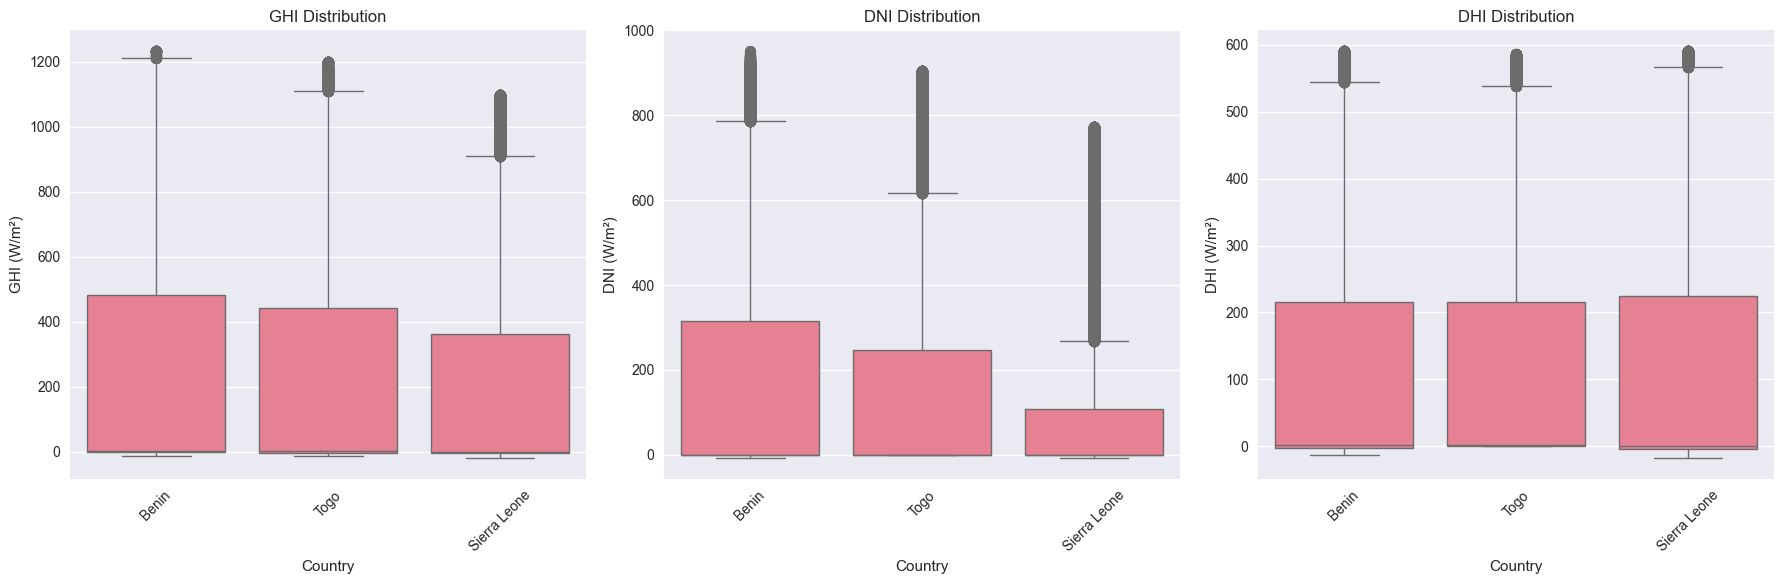

In [10]:
# Cell 3: Visualization Functions
def create_comparison_boxplots(combined_df: pd.DataFrame, metrics: List[str]):
    """
    Create side-by-side boxplots for multiple metrics across countries
    """
    available_metrics = [metric for metric in metrics if metric in combined_df.columns]
    
    n_metrics = len(available_metrics)
    if n_metrics == 0:
        print("No available metrics found for plotting")
        return
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 6))
    if n_metrics == 1:
        axes = [axes]
    
    for i, metric in enumerate(available_metrics):
        sns.boxplot(data=combined_df, x='Country', y=metric, ax=axes[i])
        axes[i].set_title(f'{metric} Distribution')
        axes[i].set_ylabel(f'{metric} (W/m²)')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_ranking_visualization(rankings_df: pd.DataFrame, metric: str):
    """
    Create visualization for country rankings
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Mean values bar chart
    countries = rankings_df.index
    means = rankings_df['mean']
    
    bars = ax1.bar(countries, means, color=['#2E8B57', '#4682B4', '#D2691E'], alpha=0.8)
    ax1.set_title(f'Country Ranking by Average {metric}', fontweight='bold')
    ax1.set_ylabel(f'Average {metric} (W/m²)')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, means):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(means)*0.01, 
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Consistency (Coefficient of Variation)
    consistency = 1 / rankings_df['cv']  # Inverse of CV for better visualization
    bars2 = ax2.bar(countries, consistency, color=['#2E8B57', '#4682B4', '#D2691E'], alpha=0.8)
    ax2.set_title('Solar Resource Consistency\n(Higher = More Consistent)', fontweight='bold')
    ax2.set_ylabel('Consistency Score (1/CV)')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create visualizations
metrics = ['GHI', 'DNI', 'DHI']
print("=== 1. SOLAR METRICS COMPARISON ===")
create_comparison_boxplots(combined_df, metrics)

In [11]:
# Cell 4: Statistical Analysis Functions
def calculate_summary_statistics(combined_df: pd.DataFrame, metrics: List[str]) -> pd.DataFrame:
    """
    Calculate comprehensive summary statistics for metrics across countries
    """
    available_metrics = [metric for metric in metrics if metric in combined_df.columns]
    
    summary_data = []
    for metric in available_metrics:
        stats_by_country = combined_df.groupby('Country')[metric].agg([
            'count', 'mean', 'median', 'std', 'min', 'max', 
            lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)
        ]).round(2)
        
        stats_by_country.columns = ['count', 'mean', 'median', 'std', 'min', 'max', 'q25', 'q75']
        stats_by_country['metric'] = metric
        stats_by_country['cv'] = (stats_by_country['std'] / stats_by_country['mean']).round(3)
        
        summary_data.append(stats_by_country)
    
    summary_df = pd.concat(summary_data)
    return summary_df.reset_index().set_index(['Country', 'metric'])

def perform_statistical_tests(data_dict: Dict[str, pd.DataFrame], metric: str) -> Dict:
    """
    Perform statistical tests to compare countries
    """
    results = {}
    
    # Extract data for each country
    country_data = {}
    for country, df in data_dict.items():
        if metric in df.columns:
            country_data[country] = df[metric].dropna()
    
    if len(country_data) < 2:
        return {"error": "Not enough countries with data for statistical tests"}
    
    # One-way ANOVA
    try:
        f_stat, p_value_anova = stats.f_oneway(*country_data.values())
        results['anova'] = {
            'f_statistic': f_stat,
            'p_value': p_value_anova,
            'significant': p_value_anova < 0.05
        }
    except:
        results['anova'] = {'error': 'ANOVA test failed'}
    
    # Kruskal-Wallis test
    try:
        h_stat, p_value_kw = stats.kruskal(*country_data.values())
        results['kruskal_wallis'] = {
            'h_statistic': h_stat,
            'p_value': p_value_kw,
            'significant': p_value_kw < 0.05
        }
    except:
        results['kruskal_wallis'] = {'error': 'Kruskal-Wallis test failed'}
    
    return results

# Perform statistical analysis
print("=== 2. STATISTICAL ANALYSIS ===")
summary_df = calculate_summary_statistics(combined_df, metrics)
print("Summary Statistics:")
display(summary_df[['mean', 'median', 'std', 'cv']])

print("\nStatistical Tests for GHI:")
test_results = perform_statistical_tests(data_dict, 'GHI')

if 'anova' in test_results and 'error' not in test_results['anova']:
    anova = test_results['anova']
    print(f"ANOVA - F-statistic: {anova['f_statistic']:.4f}, p-value: {anova['p_value']:.4f}")
    print(f"Significant differences: {anova['significant']}")

if 'kruskal_wallis' in test_results and 'error' not in test_results['kruskal_wallis']:
    kw = test_results['kruskal_wallis']
    print(f"Kruskal-Wallis - H-statistic: {kw['h_statistic']:.4f}, p-value: {kw['p_value']:.4f}")
    print(f"Significant differences: {kw['significant']}")

=== 2. STATISTICAL ANALYSIS ===
Summary Statistics:


,,mean,median,std,cv
Country,metric,,,,
Benin,GHI,240.55,1.8,331.11,1.376
Sierra Leone,GHI,201.61,0.3,297.38,1.475
Togo,GHI,230.53,2.1,322.44,1.399
Benin,DNI,167.19,-0.1,261.71,1.565
Sierra Leone,DNI,115.68,-0.1,216.42,1.871
Togo,DNI,151.19,0.0,250.76,1.659
Benin,DHI,115.10,1.6,157.87,1.372
Sierra Leone,DHI,113.47,-0.1,158.11,1.393
Togo,DHI,116.18,2.5,155.69,1.340



Statistical Tests for GHI:
ANOVA - F-statistic: 2134.1190, p-value: 0.0000
Significant differences: True
Kruskal-Wallis - H-statistic: 4526.5883, p-value: 0.0000
Significant differences: True


=== 3. COUNTRY RANKINGS ===
Country Rankings by Solar Potential:


,count,mean,median,std,min,max,q25,q75,cv,mean_rank,consistency_rank,overall_score,overall_rank
Country,,,,,,,,,,,,,
Benin,525600,240.55,1.8,331.11,-12.9,1233.95,-2.0,483.4,1.376,1.0,1.0,1.0,1.0
Togo,525600,230.53,2.1,322.44,-12.7,1198.00,-2.2,442.4,1.399,2.0,2.0,2.0,2.0
Sierra Leone,525600,201.61,0.3,297.38,-19.5,1097.44,-2.8,362.4,1.475,3.0,3.0,3.0,3.0


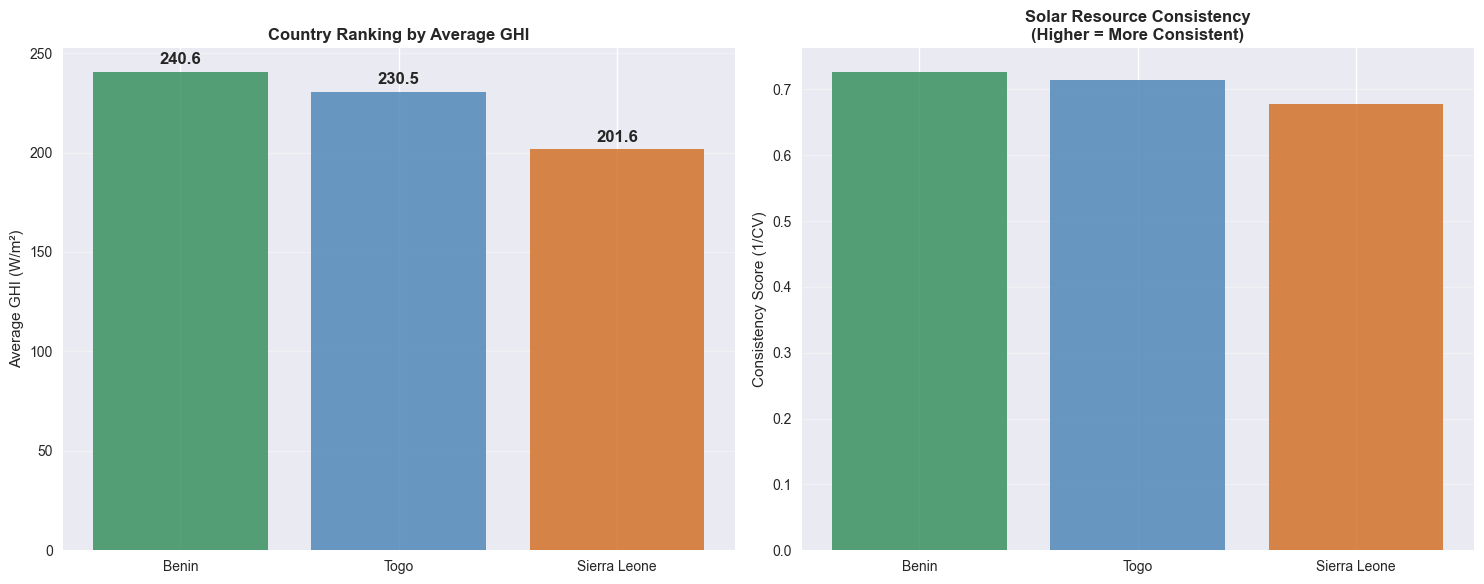

🔍 **KEY INSIGHTS:**
• **Highest Solar Potential**: Benin leads with average GHI of 240.6 W/m²
• **Resource Consistency**: Benin shows the most stable solar patterns
• **Statistical Significance**: Countries are significantly different in solar potential
• **Deployment Recommendation**: Benin is ideal for solar projects due to high potential and moderate consistency


In [12]:
# Cell 5: Ranking and Insights Functions
def generate_country_rankings(summary_df: pd.DataFrame, metric: str = 'GHI') -> pd.DataFrame:
    """
    Generate rankings of countries based on solar metrics
    """
    if metric not in summary_df.index.get_level_values('metric').unique():
        available_metrics = summary_df.index.get_level_values('metric').unique()
        print(f"Metric '{metric}' not found. Available: {list(available_metrics)}")
        return None
    
    # Filter for the specific metric
    metric_data = summary_df.xs(metric, level='metric')
    
    # Create ranking based on multiple criteria
    rankings = metric_data.copy()
    rankings['mean_rank'] = rankings['mean'].rank(ascending=False)
    rankings['consistency_rank'] = rankings['cv'].rank()  # Lower CV = better consistency
    rankings['overall_score'] = (rankings['mean_rank'] + rankings['consistency_rank']) / 2
    rankings['overall_rank'] = rankings['overall_score'].rank()
    
    return rankings.sort_values('overall_rank')

def generate_key_insights(rankings_df: pd.DataFrame, test_results: Dict):
    """
    Generate actionable insights from the analysis
    """
    best_country = rankings_df.index[0]
    best_mean = rankings_df.loc[best_country, 'mean']
    best_cv = rankings_df.loc[best_country, 'cv']
    
    most_consistent = rankings_df['cv'].idxmin()
    least_consistent = rankings_df['cv'].idxmax()
    
    print("🔍 **KEY INSIGHTS:**")
    print(f"• **Highest Solar Potential**: {best_country} leads with average GHI of {best_mean:.1f} W/m²")
    print(f"• **Resource Consistency**: {most_consistent} shows the most stable solar patterns")
    print(f"• **Statistical Significance**: Countries are {'significantly different' if test_results.get('anova', {}).get('significant', False) else 'not significantly different'} in solar potential")
    
    if best_cv < 0.3:
        consistency_note = "excellent consistency"
    elif best_cv < 0.5:
        consistency_note = "good consistency"
    else:
        consistency_note = "moderate consistency"
        
    print(f"• **Deployment Recommendation**: {best_country} is ideal for solar projects due to high potential and {consistency_note}")

# Generate rankings and insights
print("=== 3. COUNTRY RANKINGS ===")
rankings_df = generate_country_rankings(summary_df, 'GHI')
print("Country Rankings by Solar Potential:")
display(rankings_df)

create_ranking_visualization(rankings_df, 'GHI')
generate_key_insights(rankings_df, test_results)

In [14]:
# Cell 6: Export Functions
def export_comparison_results(combined_df: pd.DataFrame, summary_df: pd.DataFrame, 
                            rankings_df: pd.DataFrame = None):
    """
    Export comparison results to CSV files
    """
    import os
    os.makedirs('data', exist_ok=True)
    
    # Export combined data
    combined_df.to_csv('../data/all_countries_comparison.csv', index=False)
    print(f"✅ Combined data exported: data/all_countries_comparison.csv")
    
    # Export summary statistics
    summary_df.to_csv('../data/country_comparison_stats.csv')
    print(f"✅ Summary statistics exported: data/country_comparison_stats.csv")
    
    # Export rankings if provided
    if rankings_df is not None:
        rankings_df.to_csv('../data/country_rankings.csv')
        print(f"✅ Country rankings exported: data/country_rankings.csv")

# Export results
print("=== 4. EXPORTING RESULTS ===")
export_comparison_results(combined_df, summary_df, rankings_df)

print("\n" + "="*50)
print("🎯 TASK 3 COMPLETED SUCCESSFULLY!")
print("="*50)

=== 4. EXPORTING RESULTS ===
✅ Combined data exported: data/all_countries_comparison.csv
✅ Summary statistics exported: data/country_comparison_stats.csv
✅ Country rankings exported: data/country_rankings.csv

🎯 TASK 3 COMPLETED SUCCESSFULLY!
